In [89]:
import pickle as pkl
import matplotlib.pyplot as plt
import random
from random import sample 
import pandas as pd
import seaborn as sns
import numpy as np
import re
from wordcloud import WordCloud
import os
import json
from tqdm import tqdm
import networkx as nx
import pickle
# plot mention matrix
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

## Text analysis
Main responsible Andreas

In [90]:
with open(r"LargeData\Graph_all.pkl", 'rb') as file:
    graph = pickle.load(file)

In [91]:
#Make graph of how people interact with each other
flair_list = ["intp","intj","entp","entj","infj","infp","enfj","enfp","istj","isfj","estj","esfj","istp","isfp","estp","esfp"]
extended_flair_list = flair_list + ["submissions"]

mention_dict = {}
id_dict = {}
text_dict = {}
for flair in flair_list:
    temp_dict = {}
    temp_dict_id = {}
    temp_dict_text = {}
    for temp_flair in extended_flair_list:
        temp_dict[temp_flair] = 0
        temp_dict_id[temp_flair] = []
        temp_dict_text[temp_flair] = []
    

    mention_dict[flair] = temp_dict 
    id_dict[flair] = temp_dict_id
    text_dict[flair] = temp_dict_text

for edge in graph.edges:
    author = edge[0]
    addressee = edge[1]

    

    #Check if node is empty
    if graph.nodes[addressee] == {} or graph.nodes[author] == {}:
        continue

    author_flair = graph.nodes[author]['flair']
    addressee_flair = graph.nodes[addressee]['flair']
    if author_flair not in flair_list: 
        continue

    mention_dict[author_flair][addressee_flair] += 1
    id_dict[author_flair][addressee_flair].append(graph.edges[edge]['comment_id'])
    text_dict[author_flair][addressee_flair].append(graph.edges[edge]['comment'])

for node in graph.nodes:
    if graph.nodes[node] == {}: 
        continue
    author_flair = graph.nodes[node]['flair']
    if author_flair not in flair_list: 
        continue
    mention_dict[author_flair]["submissions"] += len(graph.nodes[node]['submissions_id'])
    id_dict[author_flair]["submissions"].extend(graph.nodes[node]['submissions_id'])
    text_dict[author_flair]["submissions"].extend(graph.nodes[node]['submissions'])


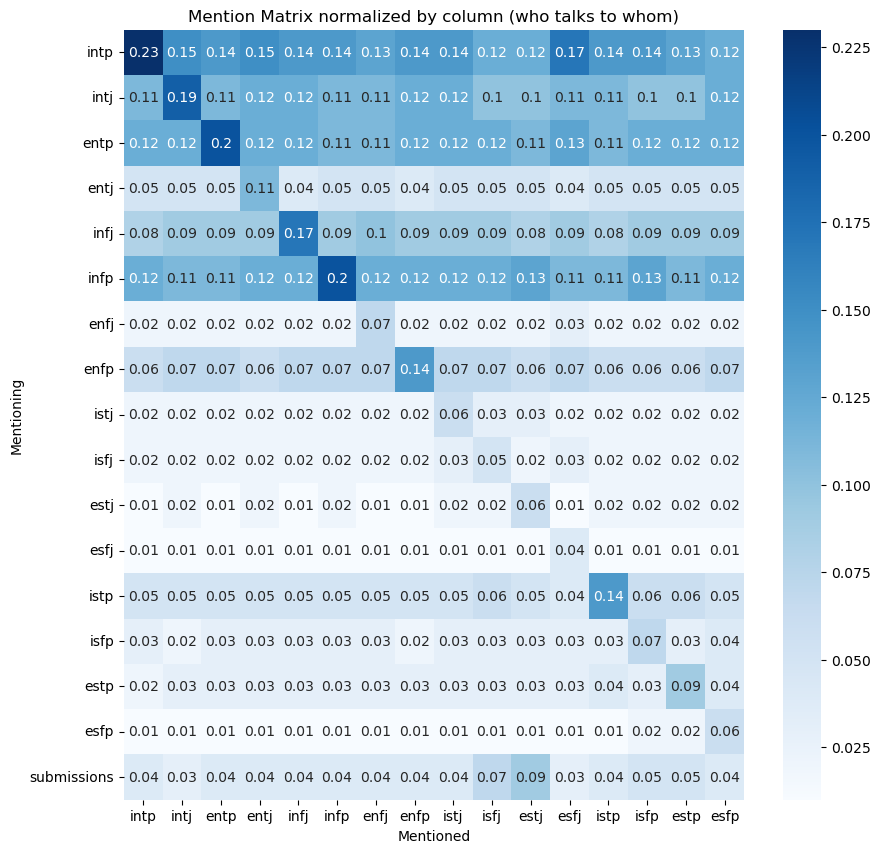

In [92]:
# plot mention matrix

mention_matrix = pd.DataFrame.from_dict(mention_dict)

#normalize by row and round to 2 decimal places
temp_mention_matrix = mention_matrix.div(mention_matrix.sum(axis=0), axis=1).round(2)

plt.figure(figsize=(10,10))
sns.heatmap(temp_mention_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Mention Matrix normalized by column (who talks to whom)')
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()


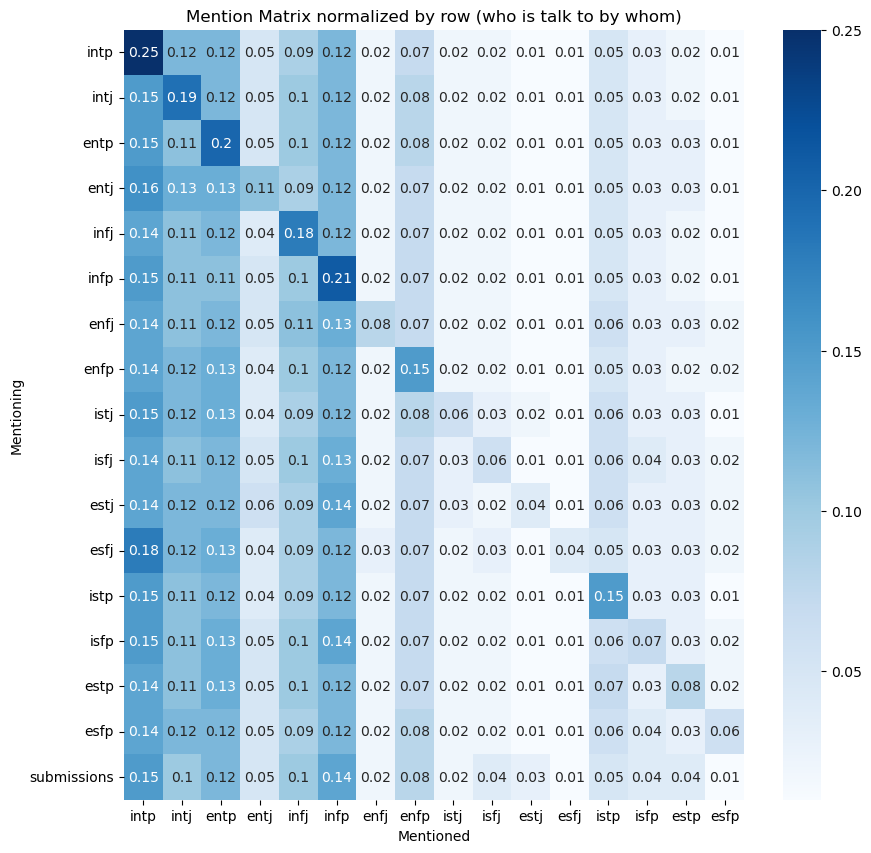

In [93]:
mention_matrix = pd.DataFrame.from_dict(mention_dict)

#normalize by column and round to 2 decimal places
temp_mention_matrix = mention_matrix.div(mention_matrix.sum(axis=1), axis=0).round(2)

plt.figure(figsize=(10,10))
sns.heatmap(temp_mention_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Mention Matrix normalized by row (who is talk to by whom)')
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()

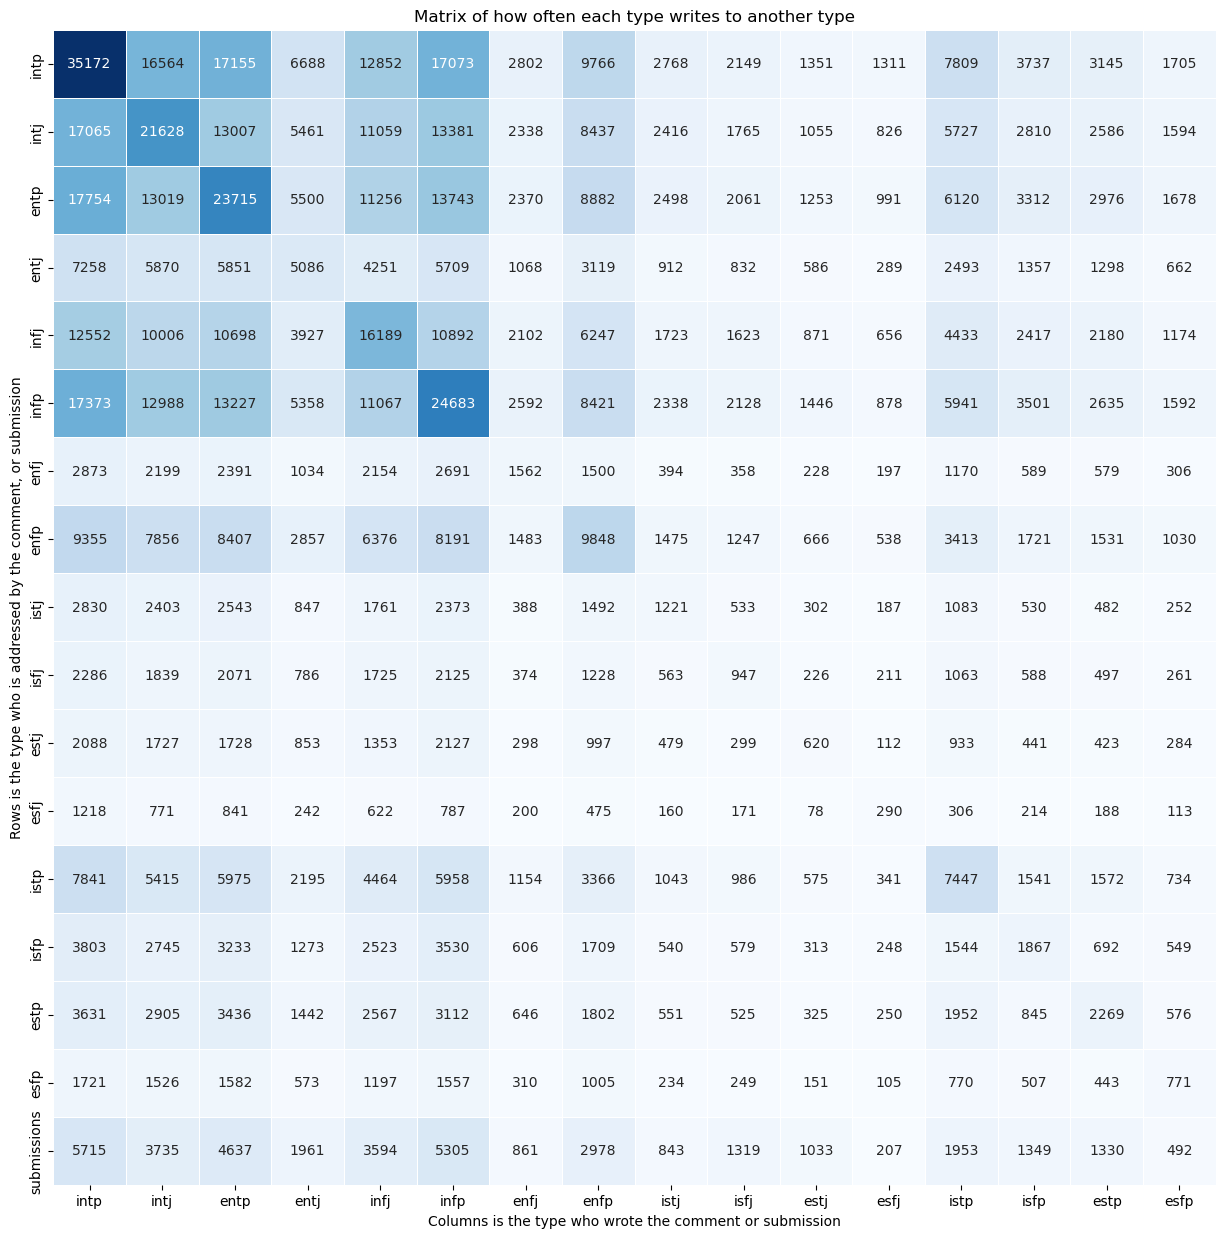

In [94]:
#Matrix of how often each type writes to another type goest to report

mention_matrix = pd.DataFrame.from_dict(mention_dict)


plt.figure(figsize=(15,15))
sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='Blues',linewidth=.5,cbar=False)
plt.title('Matrix of how often each type writes to another type')
plt.ylabel('Rows is the type who is addressed by the comment, or submission')
plt.xlabel('Columns is the type who wrote the comment or submission')

plt.show()


# Sentiment analysis

In [95]:
"""
#Old way to calculate sentiemnt that focus on document level
#Load sentiment dictionary
sentiment_frame=pd.read_csv("sentiment.txt",index_col=0,sep="\t")
sentiment_score=sentiment_frame.to_dict()["happiness_average"]

#Calculate mean sentiment of each post
def calculate_sentiment(text, sentiment_dict):
    sentiment = []
    for doc in text:
        temp_list = [] 
        for word in doc:
            if word in sentiment_dict:
                temp_list.append(sentiment_dict[word])
        if len(temp_list) == 0:
            continue
        else:
            sentiment.append(np.mean(temp_list))
    return sentiment
"""


'\n#Old way to calculate sentiemnt that focus on document level\n#Load sentiment dictionary\nsentiment_frame=pd.read_csv("sentiment.txt",index_col=0,sep="\t")\nsentiment_score=sentiment_frame.to_dict()["happiness_average"]\n\n#Calculate mean sentiment of each post\ndef calculate_sentiment(text, sentiment_dict):\n    sentiment = []\n    for doc in text:\n        temp_list = [] \n        for word in doc:\n            if word in sentiment_dict:\n                temp_list.append(sentiment_dict[word])\n        if len(temp_list) == 0:\n            continue\n        else:\n            sentiment.append(np.mean(temp_list))\n    return sentiment\n'

In [96]:


#Load sentiment dictionary 
sentiment_frame=pd.read_csv("sentiment.txt",index_col=0,sep="\t")
sentiment_score=sentiment_frame.to_dict()["happiness_average"]

#Calculate mean sentiment of each word
def calculate_sentiment(text, sentiment_dict):
    sentiment = []
    for doc in text:
        temp_list = [] 
        for word in doc:
            if word in sentiment_dict:
                temp_list.append(sentiment_dict[word])
        if len(temp_list) == 0:
            continue
        else:
            sentiment.extend(temp_list)
    return sentiment


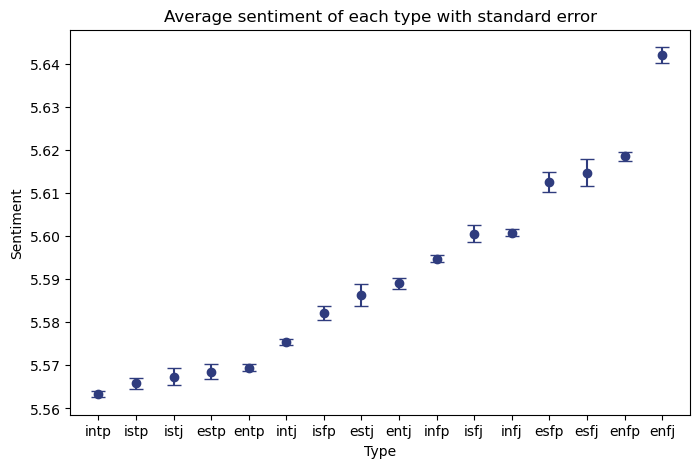

In [119]:
# Sentiment of each flair goes to the report
sentiment_list =  []
sem_list = [] 


for flair in flair_list:
    temp_list = []
    for temp_flair in extended_flair_list:
        temp_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))
    
    # Calculate mean sentiment
    sentiment_list.append(np.mean(temp_list))
    
    # Calculate standard error (SEM)
    sem = np.std(temp_list) / np.sqrt(len(temp_list))
    sem_list.append(sem)


# Make a sorted plot
temp_sentiment_list, tmp_flair_list ,temp_sem_list = zip(*sorted(zip(sentiment_list, flair_list, sem_list)))

# bar plot over sentiment of each flair sorted from highest to lowest
plt.figure(figsize=(8,5))



plt.errorbar(tmp_flair_list, temp_sentiment_list,yerr=temp_sem_list, color="#2F3C7E", fmt='o', capsize=5)
plt.title("Average sentiment of each type with standard error")
plt.ylabel("Sentiment")
plt.xlabel("Type")
plt.show()

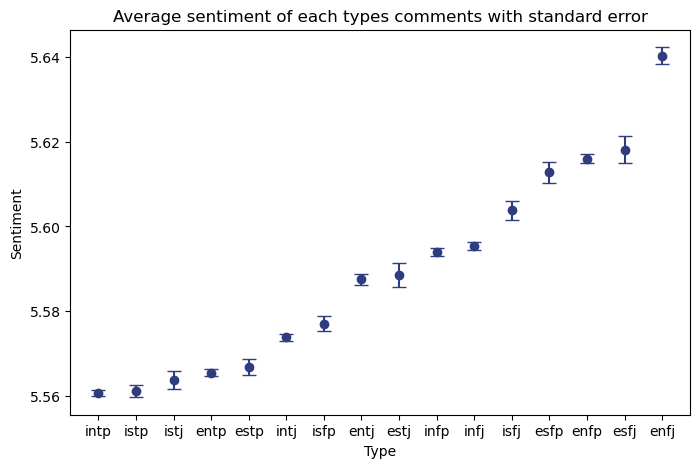

In [111]:
# Sentiment of comments
sentiment_list_comments =  []
sem_list_comments = [] 

for flair in flair_list:
    temp_list = []
    for temp_flair in flair_list:
        temp_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))
    
    # Calculate mean sentiment
    sentiment_list_comments.append(np.mean(temp_list))
    
    # Calculate standard error (SEM)
    sem = np.std(temp_list) / np.sqrt(len(temp_list))
    sem_list_comments.append(sem)


# Make a sorted plot
temp_sentiment_list, tmp_flair_list ,temp_sem_list = zip(*sorted(zip(sentiment_list_comments, flair_list, sem_list_comments)))

# bar plot over sentiment of each flair sorted from highest to lowest
plt.figure(figsize=(8,5))



plt.errorbar(tmp_flair_list, temp_sentiment_list,yerr=temp_sem_list, color="#2F3C7E", fmt='o', capsize=5)
plt.title("Average sentiment of each types comments with standard error")
plt.ylabel("Sentiment")
plt.xlabel("Type")
plt.show()

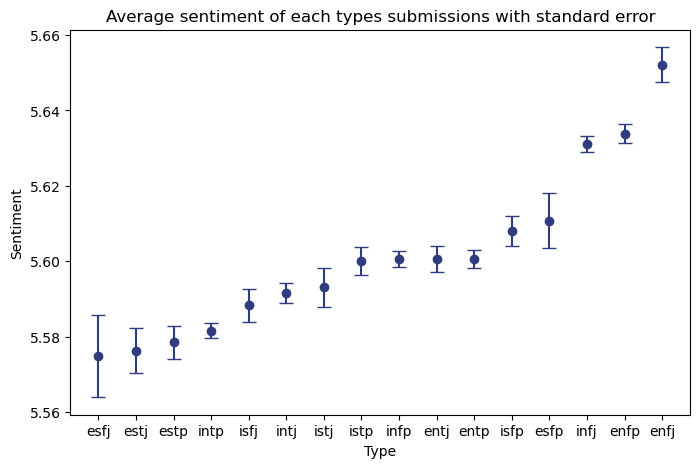

In [112]:
# Sentiment of  submission
sentiment_list_submissions =  []
sem_list_submissions = [] 

for flair in flair_list:
    temp_list = calculate_sentiment(text_dict[flair]["submissions"],sentiment_score)
    
    # Calculate mean sentiment
    sentiment_list_submissions.append(np.mean(temp_list))
    
    # Calculate standard error (SEM)
    sem = np.std(temp_list) / np.sqrt(len(temp_list))
    sem_list_submissions.append(sem)


# Make a sorted plot
temp_sentiment_list, tmp_flair_list ,temp_sem_list = zip(*sorted(zip(sentiment_list_submissions, flair_list, sem_list_submissions)))

# bar plot over sentiment of each flair sorted from highest to lowest
plt.figure(figsize=(8,5))



plt.errorbar(tmp_flair_list, temp_sentiment_list,yerr=temp_sem_list, color="#2F3C7E", fmt='o', capsize=5)
plt.title("Average sentiment of each types submissions with standard error")
plt.ylabel("Sentiment")
plt.xlabel("Type")
plt.show()

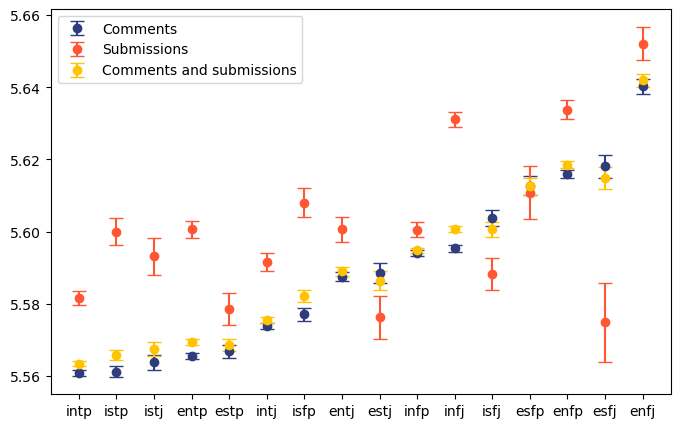

In [110]:
#Make all plots together
plt.figure(figsize=(8,5))
comment_mean,comment_sem ,submission_mean,submission_sem ,post_mean,post_sem,temp_flair = zip(*sorted(zip(sentiment_list_comments, sem_list_comments, sentiment_list_submissions, sem_list_submissions, sentiment_list, sem_list, flair_list)))


plt.errorbar(temp_flair, comment_mean,yerr=comment_sem, color="#2F3C7E", fmt='o', capsize=5, label="Comments")
plt.errorbar(temp_flair, submission_mean,yerr=submission_sem, color="#FF5733", fmt='o', capsize=5, label="Submissions")
plt.errorbar(temp_flair, post_mean,yerr=post_sem, color="#FFC300", fmt='o', capsize=5, label="Comments and submissions")
plt.legend()
plt.show()

# Investigate sentiment between character traits

In [101]:
from scipy.stats import ttest_ind


In [125]:
# Sort for careters traits and make sentinemnt analysis and t-test
F_sentiment_list =  []
for flair in ["infj","infp","enfj","enfp","isfj","isfp","esfj","esfp"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        F_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

T_sentiment_list =  []
for flair in ["intp","intj","entp","entj","istj","istp","estj","estp"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        T_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

print("F vs T")
print(ttest_ind(F_sentiment_list, T_sentiment_list,equal_var=False, alternative="greater"))

S_sentiment_list =  []
for flair in ["estp","estj","esfp","esfj","isfp","isfj","isfp","isfj"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        S_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

N_sentiment_list =  []
for flair in ["intp","intj","entp","entj","infj","infp","enfj","enfp"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        N_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

print("S vs N")
print(ttest_ind(S_sentiment_list, N_sentiment_list,equal_var=False, alternative="greater"))

J_sentiment_list =  []
for flair in ["intj","infj","entj","enfj","istj","isfj","estj","esfj"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        J_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

P_sentiment_list =  []
for flair in ["intp","infp","entp","enfp","istp","isfp","estp","esfp"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        P_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

print("J vs P")
print(ttest_ind(J_sentiment_list, P_sentiment_list,equal_var=False, alternative="greater"))

E_sentiment_list =  []
for flair in ["entp","entj","enfp","enfj","estp","estj","esfp","esfj"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        E_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

I_sentiment_list =  []
for flair in ["intp","intj","infp","infj","istp","istj","isfp","isfj"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        I_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))
print("E vs I")
print(ttest_ind(E_sentiment_list, I_sentiment_list,equal_var=False, alternative="greater"))
    



F vs T
TtestResult(statistic=57.68393873042883, pvalue=0.0, df=13741785.414011795)
S vs N
TtestResult(statistic=3.6391077956176754, pvalue=0.0001367941573798055, df=3402031.2294362755)
J vs P
TtestResult(statistic=17.834850290195483, pvalue=1.8992923065191223e-71, df=12151142.956800407)
E vs I
TtestResult(statistic=18.88586237243129, pvalue=7.477532463473484e-80, df=10215779.803027842)


In [103]:
ttest_ind(S_sentiment_list, N_sentiment_list)

TtestResult(statistic=3.6456044821796527, pvalue=0.0002667649288068755, df=14568402.0)

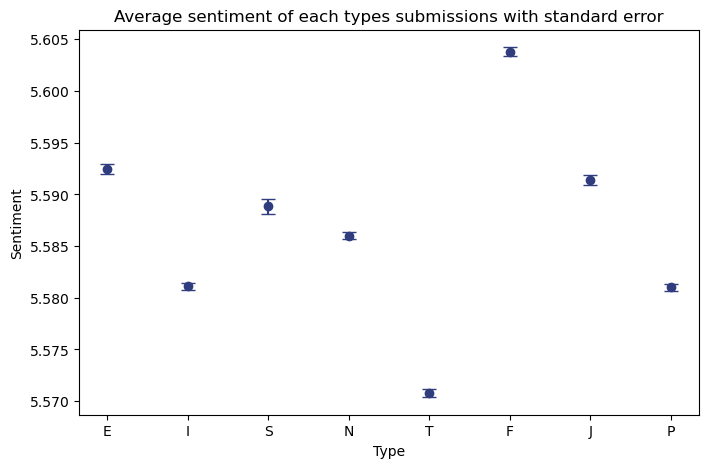

In [124]:
# Plot the difference between the two groups
sentiment_list_letters =  []
sem_list_letters = [] 

letter_list = ["E","I","S","N","T","F","J","P"]

for temp_list in [E_sentiment_list, I_sentiment_list, S_sentiment_list, N_sentiment_list, T_sentiment_list, F_sentiment_list, J_sentiment_list, P_sentiment_list]:
    
    # Calculate mean sentiment
    sentiment_list_letters.append(np.mean(temp_list))
    
    # Calculate standard error (SEM)
    sem = np.std(temp_list) / np.sqrt(len(temp_list))
    sem_list_letters.append(sem)


# Make a sorted plot
temp_sentiment_list, tmp_flair_list ,temp_sem_list = zip(*sorted(zip(sentiment_list_letters, letter_list, sem_list_letters)))

# bar plot over sentiment of each flair sorted from highest to lowest
plt.figure(figsize=(8,5))



plt.errorbar(letter_list,sentiment_list_letters,yerr=sem_list_letters, color="#2F3C7E", fmt='o', capsize=5)
plt.title("Average sentiment of each types submissions with standard error")
plt.ylabel("Sentiment")
plt.xlabel("Type")
plt.show()

# Make graph of sentiment of each interaction

In [104]:
#Make sentiment dictionary for matrix
sentiment_dict = {}
for flair in flair_list:
    temp_dict = {}
    for temp_flair in extended_flair_list:
        temp_dict[temp_flair] = np.mean(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score)) 
    sentiment_dict[flair] = temp_dict

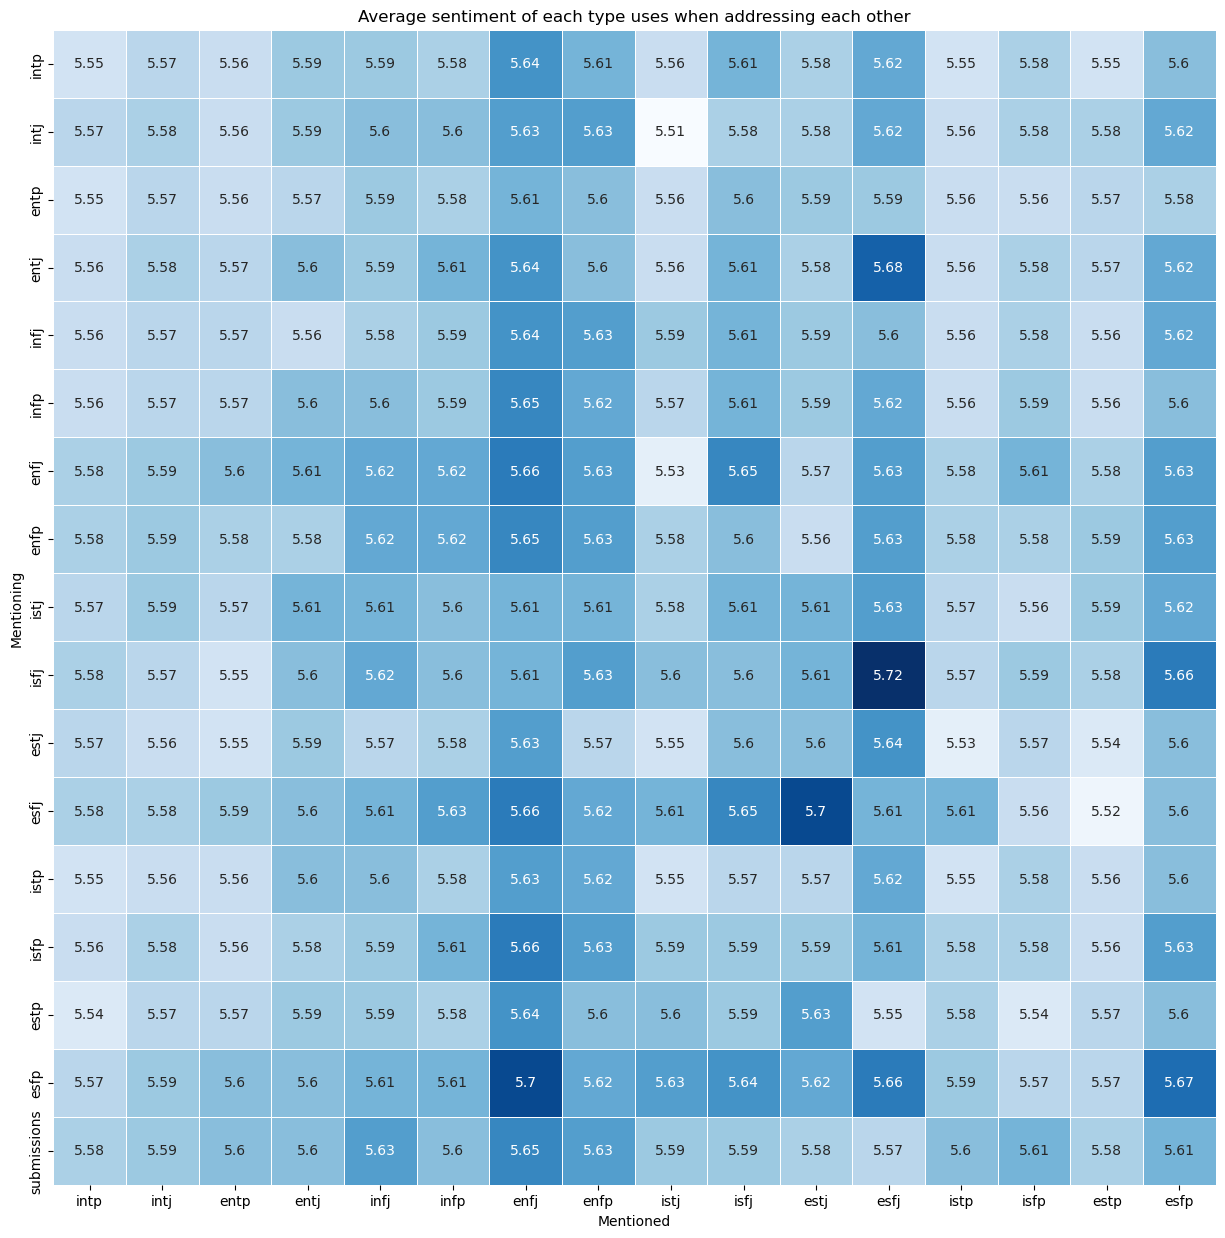

In [120]:


mention_matrix = pd.DataFrame.from_dict(sentiment_dict)


mention_matrix = mention_matrix.round(2)

plt.figure(figsize=(15,15))

sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='Blues', linewidth=.5,cbar = False)
plt.title('Average sentiment of each type uses when addressing each other')
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()

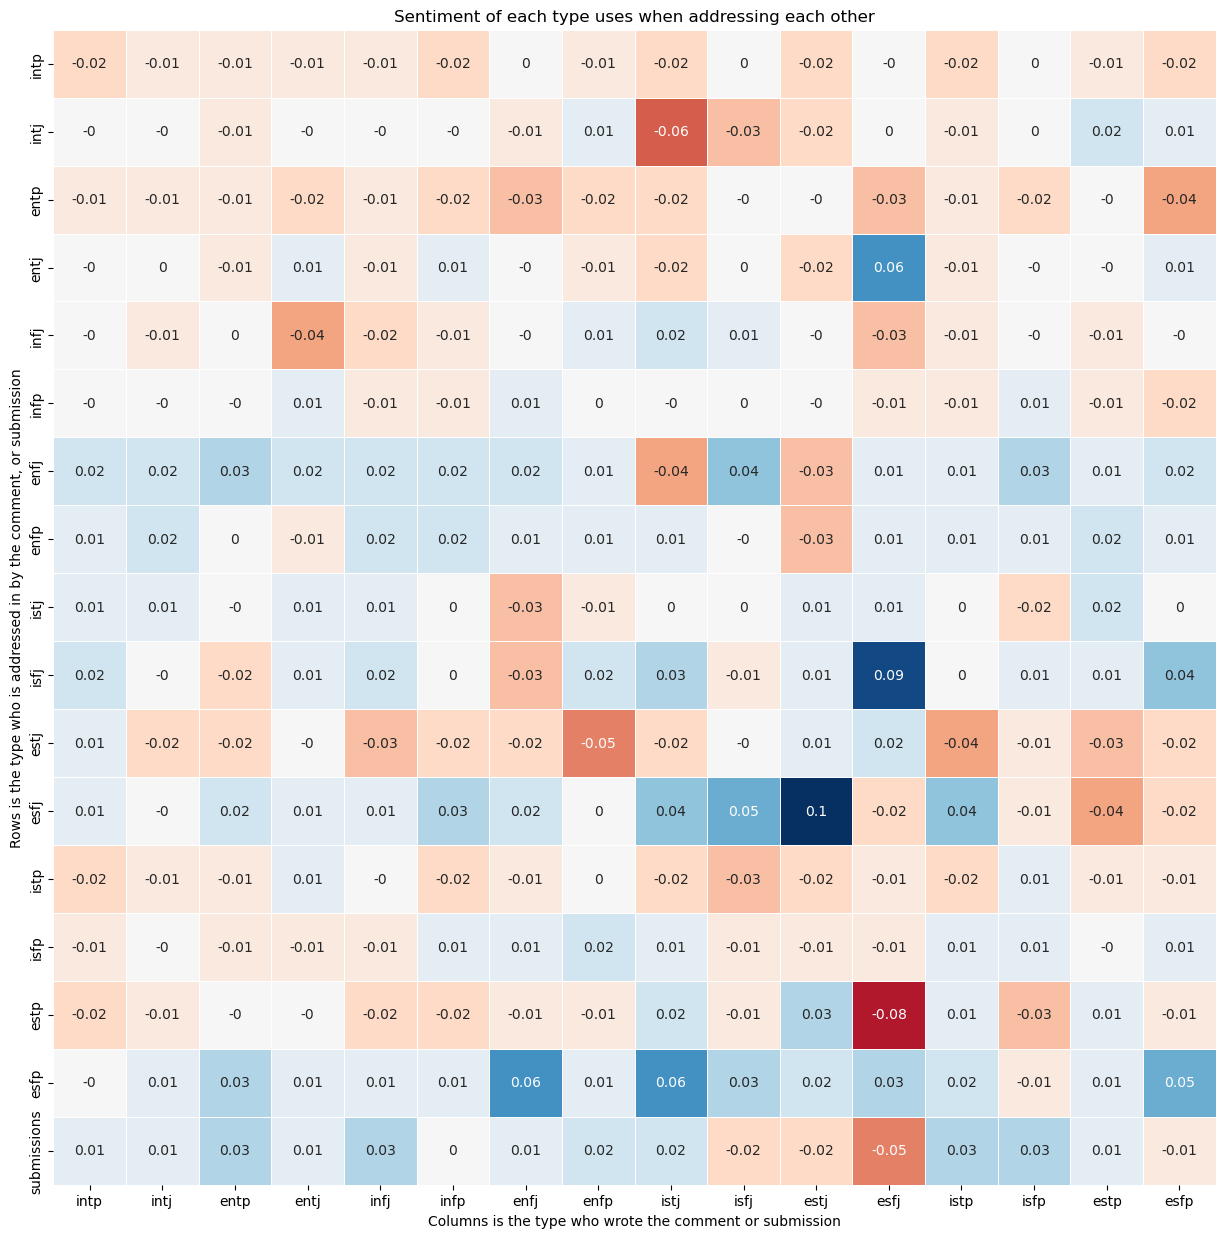

In [134]:
#Make plot for report sentiment matrix with mean subtracted mean

mention_matrix = pd.DataFrame.from_dict(sentiment_dict)




#Subtract mean sentiment of each flair from each cell
for flair in flair_list:
    mention_matrix[flair] = mention_matrix[flair] - sentiment_list[flair_list.index(flair)]

mention_matrix = mention_matrix.subtract(mention_matrix.mean(axis=0), axis=1)

mention_matrix = mention_matrix.round(2)

plt.figure(figsize=(15,15))

sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='RdBu', center=0, linewidth=.5,cbar = False)
plt.title('Sentiment of each type uses when addressing each other')
plt.ylabel('Rows is the type who is addressed in by the comment, or submission')
plt.xlabel('Columns is the type who wrote the comment or submission')

plt.show()

In [130]:
#Show some negative examples
for text in text_dict["esfj"]["estp"][100:110]:
    print(" ".join(text))
    

actually esfp estp yeah number close
ah yeah maybe read figure 1 test certainly isnt accurate
well coldblooded killer still type
think isnt much sensing v intuition love language love language may touch may something like word affection gift act service etc youve got find
yeah isnt really related entp boyfriend also love touch lot fact also definitely nedom
enneagram socionics different system understanding 8 people extremely selfconfident decisive even confrontational would say te si even
okay necessarily make sensor intuitives intuitives also fear controlled
actually matilda originally book roald dahl yes believe movie based xd sure much childthrowing
enneagram instinctual variant thing sp blindness mean dont sp instinctual variant
like type best might fun try different type like entj day


In [133]:
#Show some positive examples
for text in text_dict["esfj"]["isfj"][100:110]:
    print(" ".join(text))

lol comment made smile
making music wow hun youve got going onx got ta love exercise love squat running treadmill
know x im waiting esfjs make
type
always logic
ne dom theyre constantly crack something dont need drug
enfj reducing problem something simple solvable something love repeating process major gain hate overall enjoy math well
already know function simple thing like fe v se still get confused
definition find fe se clear many different theorist different opinion get confused
ooh im opposite im esfj mum isfj get along mom
